# Loan approval - Modélisation de la prédiction d'acceptation d'un crédit

Ce notebook couvre l’ensemble du processus de modélisation visant à prédire l'acceptation d'un crédit pour l'achat d'une maison,
à partir de données issues de précédente demandes réalisé.
L’objectif est de construire un modèle fiable pour le refus, interprétable et utilisable pour aider à prédire l'acceptation à un demande.


## Importation des librairies

In [4]:
import os
import datetime
import joblib

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, \
    f1_score

## Chargement des données

In [5]:
# Chargement des données
print("~~~ Chargement des données ~~~")

# Chargement des données d'entrainements
csv_train_path = "../data/loan_sanction_train.csv"
try:
    if not os.path.exists(csv_train_path):
        raise FileNotFoundError(f"Fichier non trouvé: {csv_train_path}")
    df = pd.read_csv(csv_train_path, low_memory=False)
    print(f"CSV file chargé avec succès. Nombre d'échantillons chargés: {df.shape[0]}")
    display(df.head())
except FileNotFoundError as e:
    print(e)

~~~ Chargement des données ~~~
CSV file chargé avec succès. Nombre d'échantillons chargés: 614


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## Exploration primaire

In [6]:
# Exploration primaire
print("~~~ Exploration primaire  ~~~")

# Explorer les types de données et les valeurs manquantes
print("• Types de données et valeurs manquantes :")
display(df.info())

# Statistiques descriptives
print("• Statistiques descriptives :")
print(df.describe())

# Afficher les statistiques descriptives
print("• Valeurs manquantes :")
print(df.isnull().sum())
loan_status = df.value_counts('Loan_Status')
print(f"•  Status crédits acceptés: {loan_status.to_list()}")

loan_status_num = pd.to_numeric(df['Loan_Status'] == 'Y').mean()
print(f"Moyen crédits acceptés: {loan_status_num:.2%}")

~~~ Exploration primaire  ~~~
• Types de données et valeurs manquantes :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


None

• Statistiques descriptives :
       ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count       614.000000         614.000000  592.000000         600.00000   
mean       5403.459283        1621.245798  146.412162         342.00000   
std        6109.041673        2926.248369   85.587325          65.12041   
min         150.000000           0.000000    9.000000          12.00000   
25%        2877.500000           0.000000  100.000000         360.00000   
50%        3812.500000        1188.500000  128.000000         360.00000   
75%        5795.000000        2297.250000  168.000000         360.00000   
max       81000.000000       41667.000000  700.000000         480.00000   

       Credit_History  
count      564.000000  
mean         0.842199  
std          0.364878  
min          0.000000  
25%          1.000000  
50%          1.000000  
75%          1.000000  
max          1.000000  
• Valeurs manquantes :
Loan_ID               0
Gender               13
Married

## Exploration détaillée

In [7]:
# Exploration détaillée
print("~~~ Exploration détaillée  ~~~")

print("• Connaissances clés sur les personnes ayant obtenu un credit")

print(f"\tTaux d'obtention: {pd.to_numeric(df['Loan_Status'] == 'Y').mean():.1%}")

print("\tGenre:")
taux_female = ((df['Gender'] == 'Female') & (df['Loan_Status'] == 'Y'))
taux_male = ((df['Gender'] == 'Male') & (df['Loan_Status'] == 'Y'))
print(f"\t\tTaux de Femmes: {taux_female.mean():.1%}")
print(f"\t\tTaux d'hommes: {taux_male.mean():.1%}")

print("\tZone de la propriété:")
taux_semiurban = ((df['Property_Area'] == 'Semiurban') & (df['Loan_Status'] == 'Y'))
taux_urban = ((df['Property_Area'] == 'Urban') & (df['Loan_Status'] == 'Y'))
taux_rural = ((df['Property_Area'] == 'Rural') & (df['Loan_Status'] == 'Y'))
print(f"\t\tTaux de habitation semiurban: {taux_semiurban.mean():.1%}")
print(f"\t\tTaux de habitation semi-urbain: {taux_urban.mean():.1%}")
print(f"\t\tTaux de habitation rural: {taux_rural.mean():.1%}")

print("\tEducation:")
taux_graduate = ((df['Education'] == 'Graduate') & (df['Loan_Status'] == 'Y'))
taux_notgraduate = ((df['Education'] == 'Not Graduate') & (df['Loan_Status'] == 'Y'))
print(f"\t\tTaux de diplômé: {taux_graduate.mean():.1%}")
print(f"\t\tTaux de non diplômé: {taux_notgraduate.mean():.1%}")

print("\tMarrié:")
taux_married = ((df['Married'] == 'Yes') & (df['Loan_Status'] == 'Y'))
taux_notmarried = ((df['Married'] == 'No') & (df['Loan_Status'] == 'Y'))
print(f"\t\tTaux de marié: {taux_married.mean():.1%}")
print(f"\t\tTaux de non marié: {taux_notmarried.mean():.1%}")

# Analyse textuelle des connaissances
print(f"• Facteurs principale d'obtention identifiés:")
print(f"\tGenre: les hommes ont un taux {taux_male.mean():.1%}")
print(f"\tZone de la propriété: vivant en semi-urbain ont un taux {taux_semiurban.mean():.1%}")
print(f"\tEducation: ayant un diplôme taux {taux_graduate.mean():.1%}")
print(f"\tMarrié: étant marié taux {taux_notgraduate.mean():.1%}")

# Analyse des valeurs manquantes
missing_analysis = df.isnull().sum()
missing_pct = (missing_analysis / len(df)) * 100
print(f"• Valeurs manquantes à traiter:")
for col, count in missing_analysis[missing_analysis > 0].items():
    print(f"    {col}: {count} ({missing_pct[col]:.1f}%)")

~~~ Exploration détaillée  ~~~
• Connaissances clés sur les personnes ayant obtenu un credit
	Taux d'obtention: 68.7%
	Genre:
		Taux de Femmes: 12.2%
		Taux d'hommes: 55.2%
	Zone de la propriété:
		Taux de habitation semiurban: 29.2%
		Taux de habitation semi-urbain: 21.7%
		Taux de habitation rural: 17.9%
	Education:
		Taux de diplômé: 55.4%
		Taux de non diplômé: 13.4%
	Marrié:
		Taux de marié: 46.4%
		Taux de non marié: 21.8%
• Facteurs principale d'obtention identifiés:
	Genre: les hommes ont un taux 55.2%
	Zone de la propriété: vivant en semi-urbain ont un taux 29.2%
	Education: ayant un diplôme taux 55.4%
	Marrié: étant marié taux 13.4%
• Valeurs manquantes à traiter:
    Gender: 13 (2.1%)
    Married: 3 (0.5%)
    Dependents: 15 (2.4%)
    Self_Employed: 32 (5.2%)
    LoanAmount: 22 (3.6%)
    Loan_Amount_Term: 14 (2.3%)
    Credit_History: 50 (8.1%)


## Exploration graphique

~~~ Exploration graphique ~~~


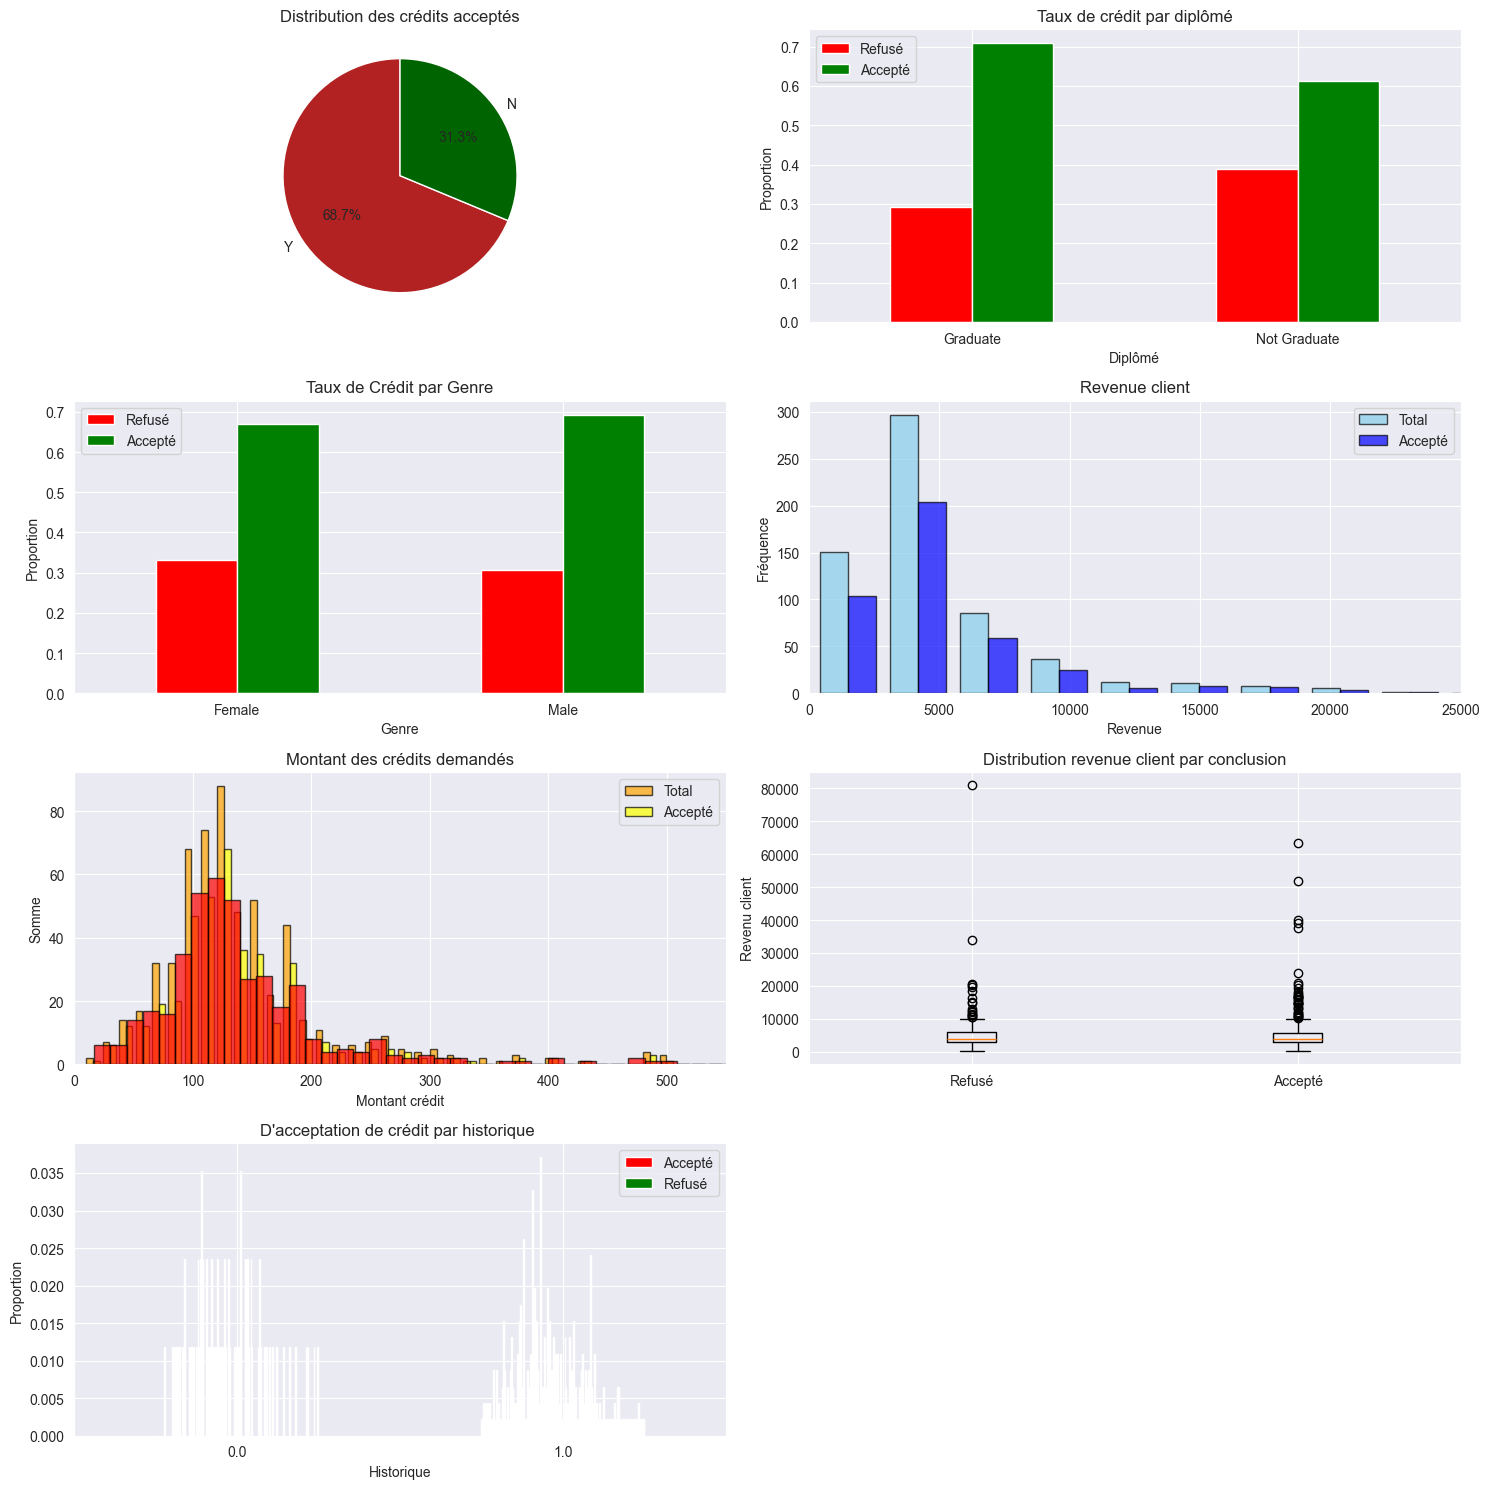

In [21]:
# Exploration graphique
print("~~~ Exploration graphique ~~~")

number_of_raw = 4
number_of_column = 2
count_pos = 0

# EDA Visualisations
plt.figure(figsize=(15, 15))

# 1. Distribution de la variable cible
count_pos += 1
plt.subplot(number_of_raw, number_of_column, count_pos)
loan_status_counts = df['Loan_Status'].value_counts()
plt.pie(loan_status_counts.values, labels=['Y', 'N'], autopct='%1.1f%%',
        colors=['firebrick', 'darkgreen'], startangle=90)
plt.title('Distribution des crédits acceptés')

# 2. Survie par education
count_pos += 1
plt.subplot(number_of_raw, number_of_column, count_pos)
survival_by_class = pd.crosstab(df['Education'], df['Loan_Status'], normalize='index')
survival_by_class.plot(kind='bar', color=['red', 'green'], ax=plt.gca())
plt.title('Taux de crédit par diplômé')
plt.xlabel('Diplômé')
plt.ylabel('Proportion')
plt.legend(['Refusé', 'Accepté'])
plt.xticks(rotation=0)

# 3. Survie par genre
count_pos += 1
plt.subplot(number_of_raw, number_of_column, count_pos)
survival_by_sex = pd.crosstab(df['Gender'], df['Loan_Status'], normalize='index')
survival_by_sex.plot(kind='bar', color=['red', 'green'], ax=plt.gca())
plt.title('Taux de Crédit par Genre')
plt.xlabel('Genre')
plt.ylabel('Proportion')
plt.legend(['Refusé', 'Accepté'])
plt.xticks(rotation=0)

# 4. Distribution par revenu client
count_pos += 1
plt.subplot(number_of_raw, number_of_column, count_pos)
plt.hist([df['ApplicantIncome'].dropna(), df[df['Loan_Status'] == 'Y']['ApplicantIncome'].dropna()], bins=30, alpha=0.7,
         color=['skyblue', 'blue'], edgecolor='black')
plt.legend(['Total', 'Accepté'])

plt.title('Revenue client')
plt.xlabel('Revenue')
plt.ylabel('Fréquence')

plt.xlim(0, 25000)  # Zoom sur les valeurs principales

# 5. Distribution par montant du prêt
count_pos += 1
plt.subplot(number_of_raw, number_of_column, count_pos)
plt.hist([df['LoanAmount'].dropna(), df[df['Loan_Status'] == 'Y']['LoanAmount'].dropna()], bins=50, alpha=0.7,
         color=['orange', 'yellow'], edgecolor='black')

plt.hist(df[df['Loan_Status'] == 'Y']['LoanAmount'].dropna(), bins=50, alpha=0.7, color='red', edgecolor='black')

plt.title('Montant des crédits demandés')
plt.xlabel('Montant crédit')
plt.ylabel('Somme')
plt.legend(['Total', 'Accepté'])

plt.xlim(0, 550)  # Zoom sur les valeurs principales

# 6. Distribution revenue client
count_pos += 1
plt.subplot(number_of_raw, number_of_column, count_pos)
survived_ages = df[df['Loan_Status'] == 'Y']['ApplicantIncome'].dropna()
died_ages = df[df['Loan_Status'] == 'N']['ApplicantIncome'].dropna()
plt.boxplot([died_ages, survived_ages], tick_labels=['Refusé', 'Accepté'])
plt.title('Distribution revenue client par conclusion')
plt.ylabel('Revenu client')

# 7. Crédit par historique de crédit
count_pos += 1
plt.subplot(number_of_raw, number_of_column, count_pos)
survival_by_port = pd.crosstab(df['Credit_History'], df['LoanAmount'], normalize='index')
survival_by_port.plot(kind='bar', color=['red', 'green'], ax=plt.gca())
plt.title('D\'acceptation de crédit par historique ')
plt.xlabel('Historique')
plt.ylabel('Proportion')
plt.legend(['Accepté', 'Refusé'])
plt.xticks(rotation=0)


plt.tight_layout()
plt.show()


## Préprocessing

Préprocessing tri

In [9]:
# Préprocessing
print("~~~ Préprocessing ~~~")

# Sélection des features pertinentes
features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area']

X = df[features].copy()
y = df['Loan_Status'] == 'N'

# Gestion des valeurs manquantes
X = X.fillna({
    'Gender': X['Gender'].mode()[0],
    'Married': X['Married'].mode()[0],
    'Self_Employed': X['Self_Employed'].mode()[0],
    'Dependents': X['Dependents'].mode()[0],
    'LoanAmount': X['LoanAmount'].median(),
    'Loan_Amount_Term': X['Loan_Amount_Term'].median(),
    'Credit_History': X['Credit_History'].median(),
})

print("• Valeurs manquantes après nettoyage :")
print(X.isnull().sum())

~~~ Préprocessing  ~~~
• Valeurs manquantes après nettoyage:
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64


## Préprocessing pipeline

In [22]:
# Préprocessing pipeline
print("~~~ Préprocessing pipeline  ~~~")

print(X.columns.tolist())

# Identification des colonnes catégorielles et numériques
categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
numerical_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

# Pipeline pour les données catégorielles (One-Hot Encoding)
# from sklearn.preprocessing import OneHotEncoder

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first', sparse_output=False))
])

# Pipeline pour les données numériques (Standardisation)
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Preprocessing complet avec ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough')

print(f'• X size: {len(X)} - shape: {X.shape}')
print(f'• y size: {len(y)} - shape: {y.shape}')

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"• Taille train: {x_train.shape[0]} échantillons")


~~~ Préprocessing pipeline  ~~~
['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area']
• X size: 614 - shape: (614, 11)
• y size: 614 - shape: (614,)
• Taille train: 491 échantillons


## Entrainement du modèle


In [11]:
# Entrainement du modèle
print("~~~ Entrainement du modèle ~~~")

# Définition du modèle de base
model = RandomForestClassifier(random_state=42)
#
# Définition des hyperparamètres à tester
param_grid = {
    'n_estimators': [50, 100, 200, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8],
    # 'loss': ('ls', 'lad', 'huber', 'quantile')
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1,
)

x_train_transformed = preprocessor.fit_transform(x_train)
# Entraînement du modèle avec GridSearch
grid_search.fit(x_train_transformed, y_train)

# Meilleurs hyperparamètres
print("• Meilleurs hyper-paramètres trouvés :")
print(grid_search.best_params_)

# Meilleur score
print(f"• Meilleur score de validation: {grid_search.best_score_:.2%}")
# Entraînement du modèle avec les meilleurs hyper-paramètres
best_model = grid_search.best_estimator_


~~~ Entrainement du modèle  ~~~
Fitting 5 folds for each of 192 candidates, totalling 960 fits
• Meilleurs hyperparamètres trouvés:
{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 400}
• Meilleur score de validation: 80.86%


## Création du modèle

In [12]:
# Création du modèle
print("~~~ Création du modèle ~~~")

# Pipeline complet: preprocessing + modèle
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', best_model)
])

# Configuration de la cross-validation stratifiée
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Scores de cross-validation
cv_scores = cross_val_score(model_pipeline, x_train, y_train, cv=cv, scoring='accuracy')

print(f"• Scores CV: {cv_scores}")
print(f"• Score CV moyen: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

model_pipeline.fit(x_train, y_train)
print("• Modèle entraîné avec succès !")

~~~ Création du modèle ~~~
• Scores CV: [0.77777778 0.76530612 0.81632653 0.89795918 0.78571429]
• Score CV moyen: 0.8086 (+/- 0.0955)
• Modèle entraîné avec succès!


## Enregistrement du modèle

In [13]:
# Enregistrement du modèle
print("~~~ Enregistrement du modèle ~~~")
x = datetime.datetime.now()
x = x.strftime("%Y-%m-%d.%H:%M:%S")
modelName = f"model_0_{x}.pkl"
print(f"• enregistrement du modèle {modelName}")

joblib.dump(model_pipeline, "../models/" + modelName)

print("• Fin de l'enregistrement' du modèle")

~~~ Enregistrement du modèle ~~~
• enregistrement du modèle model_0_2025-12-07.16:32:40.pkl
• Fin de l'enregistrement' du modèle


## Evaluation du modèle

In [14]:
# Evaluation du modèle
print("~~~ Evaluation du modèle ~~~")

# Prédiction
y_pred_train = model_pipeline.predict(x_train)
y_pred_test = model_pipeline.predict(x_test)

# Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"• Accuracy Train: {train_accuracy:.4f}")
print(f"• Accuracy Test: {test_accuracy:.4f}")

# Precision
train_precision = precision_score(y_train, y_pred_train, average='weighted')
test_precision = precision_score(y_test, y_pred_test, average='weighted')

print(f"• Précision Train: {train_precision:.4f}")
print(f"• Précision Test: {test_precision:.4f}")

# Recall Score
train_recall_score = recall_score(y_train, y_pred_train, average='weighted')
test_recall_score = recall_score(y_test, y_pred_test, average='weighted')

print(f"• recall score Train: {train_precision:.4f}")
print(f"• recall score Test: {test_precision:.4f}")

# f1 score
train_f1_score = f1_score(y_train, y_pred_train, average='weighted')
test_f1_score = f1_score(y_test, y_pred_test, average='weighted')

print(f"• F1 score Train: {train_precision:.4f}")
print(f"• F1 score Test: {test_precision:.4f}")

# Rapport de classification détaillé
print("• Rapport de classification (Test):")
print(classification_report(y_test, y_pred_test,
                            target_names=['Refusé', 'Accepté']))

# Matrice de confusion
print("• Matrice de confusion :")
cm = confusion_matrix(y_test, y_pred_test)
print(cm)

~~~ Evaluation du modèle ~~~
• Accuracy Train: 0.9022
• Accuracy Test: 0.7967
• Précision Train: 0.9078
• Précision Test: 0.7946
• recall score Train: 0.9078
• recall score Test: 0.7946
• F1 score Train: 0.9078
• F1 score Test: 0.7946
• Rapport de classification (Test):
              precision    recall  f1-score   support

      Refusé       0.80      0.94      0.86        85
     Accepté       0.78      0.47      0.59        38

    accuracy                           0.80       123
   macro avg       0.79      0.71      0.73       123
weighted avg       0.79      0.80      0.78       123

• Matrice de confusion:
[[80  5]
 [20 18]]


## Visualisation résultats

~~~ Visualisation résultats  ~~~


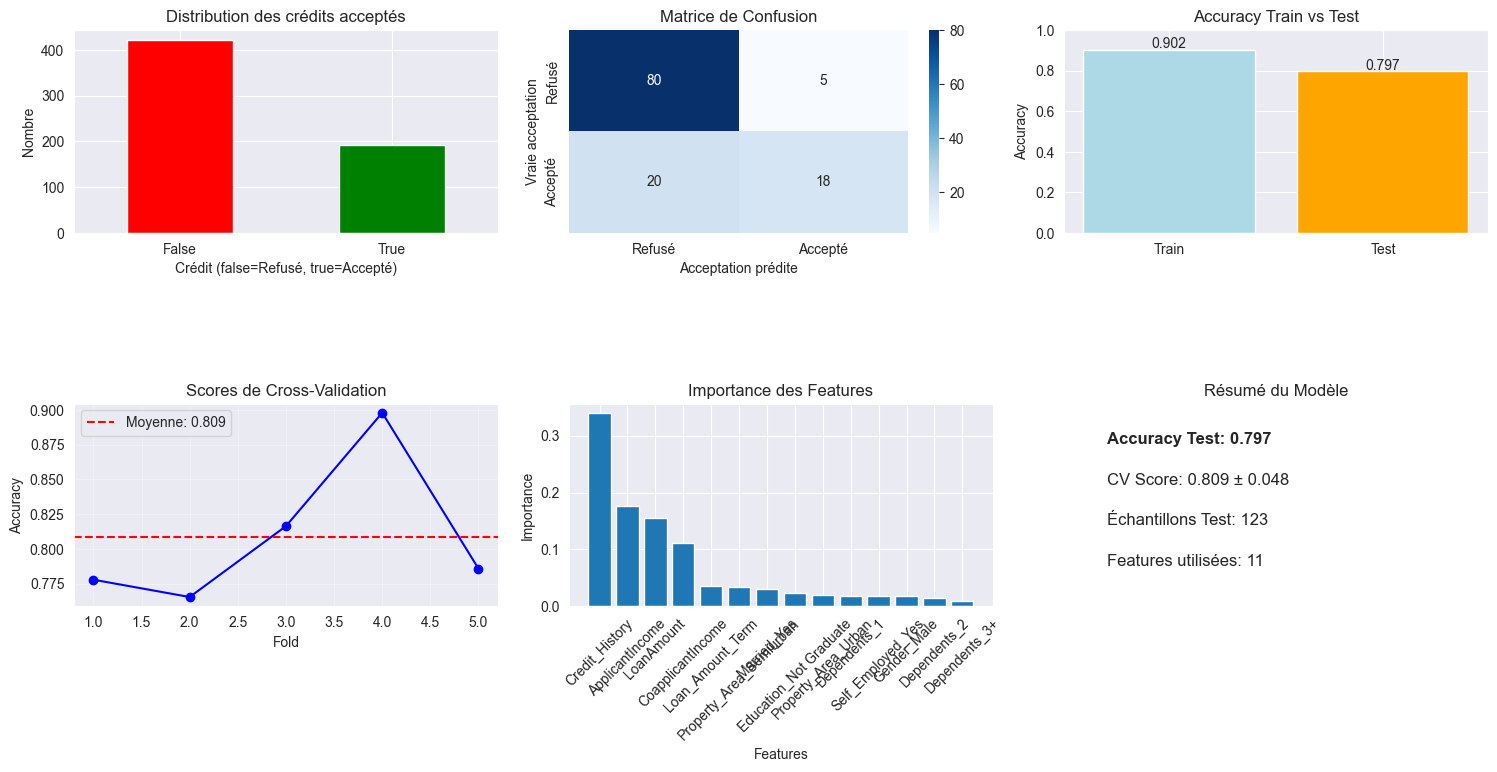

In [15]:
# Visualisation résultats
print("~~~ Visualisation résultats ~~~")

number_of_raw = 3
number_of_column = 3
count_pos = 0

# Configuration des graphiques
plt.figure(figsize=(15, 10))

# 1. Distribution des classes
count_pos += 1
plt.subplot(number_of_raw, number_of_column, count_pos)
y.value_counts().plot(kind='bar', color=['red', 'green'])
plt.title('Distribution des crédits acceptés')
plt.ylabel('Nombre')
plt.xlabel('Crédit (false=Refusé, true=Accepté)')
plt.xticks(rotation=0)

# 2. Matrice de confusion (heatmap)
count_pos += 1
plt.subplot(number_of_raw, number_of_column, count_pos)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Refusé', 'Accepté'],
            yticklabels=['Refusé', 'Accepté'])
plt.title('Matrice de Confusion')
plt.ylabel('Vraie acceptation')
plt.xlabel('Acceptation prédite')

# 3. Comparaison Train vs Test
count_pos += 1
plt.subplot(number_of_raw, number_of_column, count_pos)
scores = [train_accuracy, test_accuracy]
labels = ['Train', 'Test']
colors = ['lightblue', 'orange']
plt.bar(labels, scores, color=colors)
plt.title('Accuracy Train vs Test')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(scores):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

# 4. Scores de Cross-Validation
count_pos += 1
plt.subplot(number_of_raw, number_of_column, count_pos)
plt.plot(range(1, len(cv_scores) + 1), cv_scores, 'bo-')
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--',
            label=f'Moyenne: {cv_scores.mean():.3f}')
plt.title('Scores de Cross-Validation')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# 5. Feature Importance (si disponible)
if hasattr(model_pipeline.named_steps['classifier'], 'feature_importances_'):
    count_pos += 1
    plt.subplot(number_of_raw, number_of_column, count_pos)
    feature_names = numerical_features + categorical_features
    importances = model_pipeline.named_steps['classifier'].feature_importances_

    # Récupérer les vrais noms de features après transformation
    preprocessor = model_pipeline.named_steps['preprocessor']
    num_features = preprocessor.transformers_[0][2]
    cat_encoder = preprocessor.transformers_[1][1].named_steps['encoder']
    cat_features = cat_encoder.get_feature_names_out(preprocessor.transformers_[1][2])
    feature_names_full = list(num_features) + list(cat_features)

# Fixme: array size failure...
# Tri par importance
indices = np.argsort(importances)[::-1]

plt.bar(range(len(importances)), importances[indices])
plt.title('Importance des Features')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(range(len(importances)),
           [feature_names_full[i] for i in indices], rotation=45)

# 6. Résumé des métriques
count_pos += 1
plt.subplot(number_of_raw, number_of_column, count_pos)
plt.text(0.1, 0.8, f'Accuracy Test: {test_accuracy:.3f}', fontsize=12, fontweight='bold')
plt.text(0.1, 0.6, f'CV Score: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}', fontsize=12)
plt.text(0.1, 0.4, f'Échantillons Test: {len(y_test)}', fontsize=12)
plt.text(0.1, 0.2, f'Features utilisées: {len(feature_names)}', fontsize=12)
plt.title('Résumé du Modèle')
plt.axis('off')

plt.tight_layout()
plt.show()


## Résumé


In [16]:
# Visualisation résultats
print("~~~ Visualisation résultats ~~~")

print("~" * 50)
print("Résumé du projet Machine Learning :")
print(f"\t• Dataset: loan ({df.shape[0]} demandes)")
print(f"\t• Tâche: Classification binaire (acceptation)")
print(f"\t• Modèle: Random Forest")
print(f"\t• Features: {len(feature_names)} variables")
print(f"\t• Accuracy finale: {test_accuracy:.3f}")
print(f"\t• Score CV: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
print("~" * 50)

# Exemple de prédiction sur des clients fictifs
print("~~~ Exemple de prédiction ~~~")
print("")
clients = [
    {
        'description': 'Femme, mariée, diplômée',
        'info': pd.DataFrame({
            'Gender': ['Female'],
            'Married': ['No'],
            'Dependents': ['0'],
            'Education': ['Not Graduate'],
            'Self_Employed': ['No'],
            'ApplicantIncome': [2583],
            'CoapplicantIncome': [0],
            'LoanAmount': [200],
            'Loan_Amount_Term': [360],
            'Credit_History': [1],
            'Property_Area': ['Urban'],
        })
    },
    {
        'description': 'Femme, célibataire, sans diplôme, haut revenu',
        'info': pd.DataFrame({
            'Loan_ID': ['LP002991'],
            'Gender': ['Female'],
            'Married': ['No'],
            'Education': ['Not Graduate'],
            'Self_Employed': ['Yes'],
            'ApplicantIncome': [13000],
            'Dependents': ['2'],
            'LoanAmount': [240],
            'Loan_Amount_Term': [240],
            'CoapplicantIncome': [0],
            'Property_Area': ['Urban'],
            'Credit_History': [0],
        })
    },
    {
        'description': 'Homme, marié, diplômée',
        'info': pd.DataFrame({
            'Gender': ['Male'],
            'Married': ['No'],
            'Dependents': ['0'],
            'Education': ['Not Graduate'],
            'Self_Employed': ['No'],
            'ApplicantIncome': [2583],
            'CoapplicantIncome': [0],
            'LoanAmount': [200],
            'Loan_Amount_Term': [360],
            'Credit_History': [1],
            'Property_Area': ['Urban'],
        })
    },
    {
        'description': 'Homme, célibataire, sans diplôme, haut revenu',
        'info': pd.DataFrame({
            'Loan_ID': ['LP002991'],
            'Gender': ['Female'],
            'Married': ['No'],
            'Education': ['Not Graduate'],
            'Self_Employed': ['Yes'],
            'ApplicantIncome': [13000],
            'Dependents': ['2'],
            'LoanAmount': [240],
            'Loan_Amount_Term': [240],
            'CoapplicantIncome': [0],
            'Property_Area': ['Urban'],
            'Credit_History': [0],
        })
    }
]

for client in clients:
    info = client['info']
    prediction = model_pipeline.predict(info)[0]
    proba = model_pipeline.predict_proba(info)[0]
    print(f"Nouvelle demande de crédit: {client['description']}")
    print(f"Prédiction: {'Accepté' if prediction == 1 else 'refusé'}")
    print(f"Probabilités: Refusé={proba[0]:.2%}, Accepté={proba[1]:.2%}")
    print()
print("~" * 50)

~~~ Visualisation résultats  ~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Résumé du projet ML:
	• Dataset: loan (614 demandes)
	• Tâche: Classification binaire (acceptation)
	• Modèle: Random Forest
	• Features: 11 variables
	• Accuracy finale: 0.797
	• Score CV: 0.809 ± 0.048
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~ Exemple de prédiction ~~~

Nouvelle demande de crédit: Femme, mariée, diplômée
Prédiction: refusé
Probabilités: Refusé=53.86%, Accepté=46.14%

Nouvelle demande de crédit: Femme, célibataire, sans diplome, haut revenu
Prédiction: Accepté
Probabilités: Refusé=24.29%, Accepté=75.71%

Nouvelle demande de crédit: Homme, marié, diplômée
Prédiction: Accepté
Probabilités: Refusé=48.12%, Accepté=51.88%

Nouvelle demande de crédit: Homme, célibataire, sans diplome, haut revenu
Prédiction: Accepté
Probabilités: Refusé=24.29%, Accepté=75.71%

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
